In [1]:
!pip install tslearn

     |████████████████████████████████| 793 kB 621 kB/s 


# TimeSeriesKmeans clustering
The idea of this notebook is to cluster the different breath ids according to its shape in order to use it in the feature engineering 
The output is two csv's with the cluster to which each row of the train_set and test_set corresponds.
Although it seemed like a good idea, I did not manage to improve the CV/LB when I used it on my feature engineering models.


https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py



In [2]:
import pandas as pd
import numpy as np
import os

import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [3]:
path = '../input/ventilator-pressure-prediction'
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [4]:
X = train['u_in'].values
y = train['pressure'].values

## Elbow Method

To determine the number of clusters I used the elbow method.<br>
The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

<AxesSubplot:xlabel='clusters'>

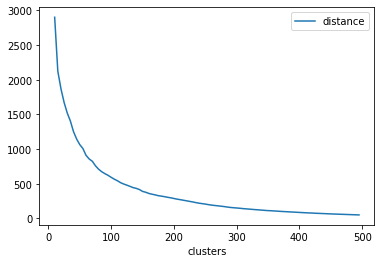

In [5]:
elbow_data = []
for n_clusters in range (10,500,5):
    train_ts = train['u_in'].values.reshape(-1, 80)
    y = train['pressure'].values
    test_ts = test['u_in'].values.reshape(-1, 80)

    X_train = train_ts[:1000] # using only first 1.000 as a sample

    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=42,n_jobs=-1)
    y_pred = km.fit_predict(X_train)
    elbow_data.append((n_clusters, km.inertia_))

pd.DataFrame(elbow_data,columns=['clusters', 'distance']).plot(x='clusters',y='distance')

In [6]:
N_CLUSTERS = 60

train_ts = train['u_in'].values.reshape(-1, 80)
y = train['pressure'].values
test_ts = test['u_in'].values.reshape(-1, 80)

X_train = train_ts[:1000]  # using only first 1.000 as a sample
y_train = y[:1000]  # using only first 1.000 as a sample


# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, verbose=False, random_state=42,n_jobs=-1)
y_pred = km.fit_predict(X_train)

print(f'Inertia: {km.inertia_}')

Inertia: 907.8577717676833


## Ploting clusters

__Black lines__: u_in of all breath ids in cluster<br>
__Red lines__: cluster u_in center<br>
__Blue lines__: pressure of all breath ids in cluster

/opt/conda/lib/python3.7/site-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 75450 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


<Figure size 432x288 with 0 Axes>

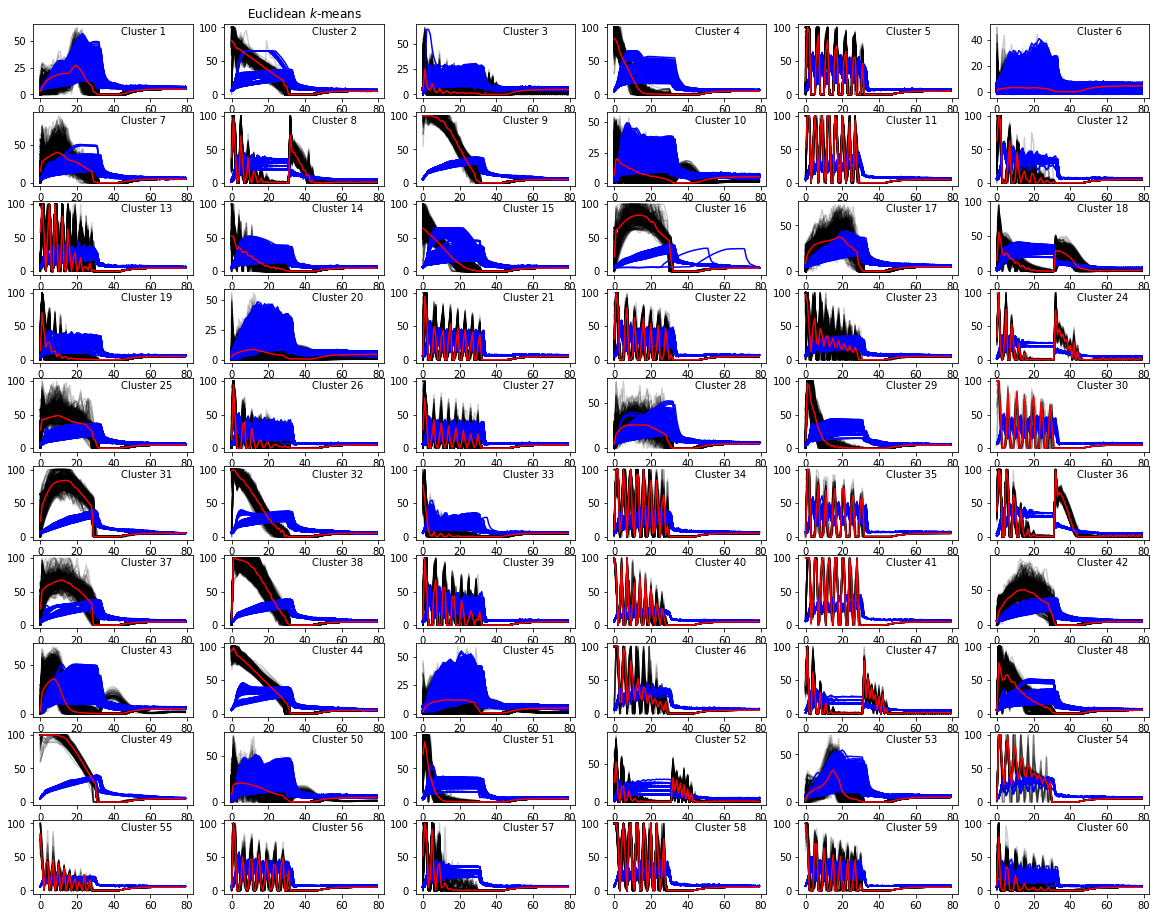

In [7]:
y_pred = km.predict(train_ts)
plt.figure()
plt.subplots(figsize = (20, 16))
for yi in range(N_CLUSTERS):
    plt.subplot(10, 6, yi + 1)
    for xx in train_ts[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    for xx in y.reshape(-1, 80)[y_pred == yi]:
        plt.plot(xx.ravel(), 'b-')
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [8]:
train_clusters = km.predict(train_ts)
test_clusters = km.predict(test_ts)

/opt/conda/lib/python3.7/site-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 75450 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/opt/conda/lib/python3.7/site-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 50300 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


###  Number Breath ids per cluster

In [9]:
pd.DataFrame(train_clusters, columns=['cluster']).value_counts().rename('count').reset_index()

,cluster,count
0,5,13607
1,19,10635
2,44,7403
3,9,6743
4,49,3877
5,2,3703
6,27,2263
7,18,1732
8,6,1554
9,16,1387


In [10]:
pd.DataFrame({'cluster':np.repeat(train_clusters, 80)}).to_csv('train_ts_clusters.csv')
pd.DataFrame({'cluster':np.repeat(test_clusters, 80)}).to_csv('test_ts_clusters.csv')